In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

df = pd.read_csv('../data/cal_fire_data_cleaned.csv')
target = 'Destroyed'
X = df.drop(columns=[target])
y = df[target]

categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.difference([target])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=216))
])

param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 4, 6, 8, 10, 12],
    'classifier__min_samples_leaf': [1, 2, 4, 8]
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=216
)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=216)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("best_params:", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
best_params: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5115
           1       0.88      0.83      0.85      3443

    accuracy                           0.89      8558
   macro avg       0.89      0.88      0.88      8558
weighted avg       0.89      0.89      0.89      8558



In [2]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

best_tree = grid_search.best_estimator_
preds = best_tree.predict(X_test)
baseline_test_acc = accuracy_score(y_test, preds)
baseline_test_balanced_acc = balanced_accuracy_score(y_test, preds)
print(baseline_test_acc)
print(baseline_test_balanced_acc)


0.8863052114980136
0.8767375913104039


In [3]:
probabilities = best_tree.predict_proba(X_test)
print(probabilities)


[[0.16666667 0.83333333]
 [0.04846939 0.95153061]
 [0.02528902 0.97471098]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]


In [4]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [5]:
print(precision_score(y_test, best_tree.predict(X_test), average=None))
print(recall_score(y_test, best_tree.predict(X_test), average=None))
print(f1_score(y_test, best_tree.predict(X_test), average=None))


[0.8887012  0.88235294]
[0.9257087  0.82776648]
[0.90682754 0.85418852]


In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


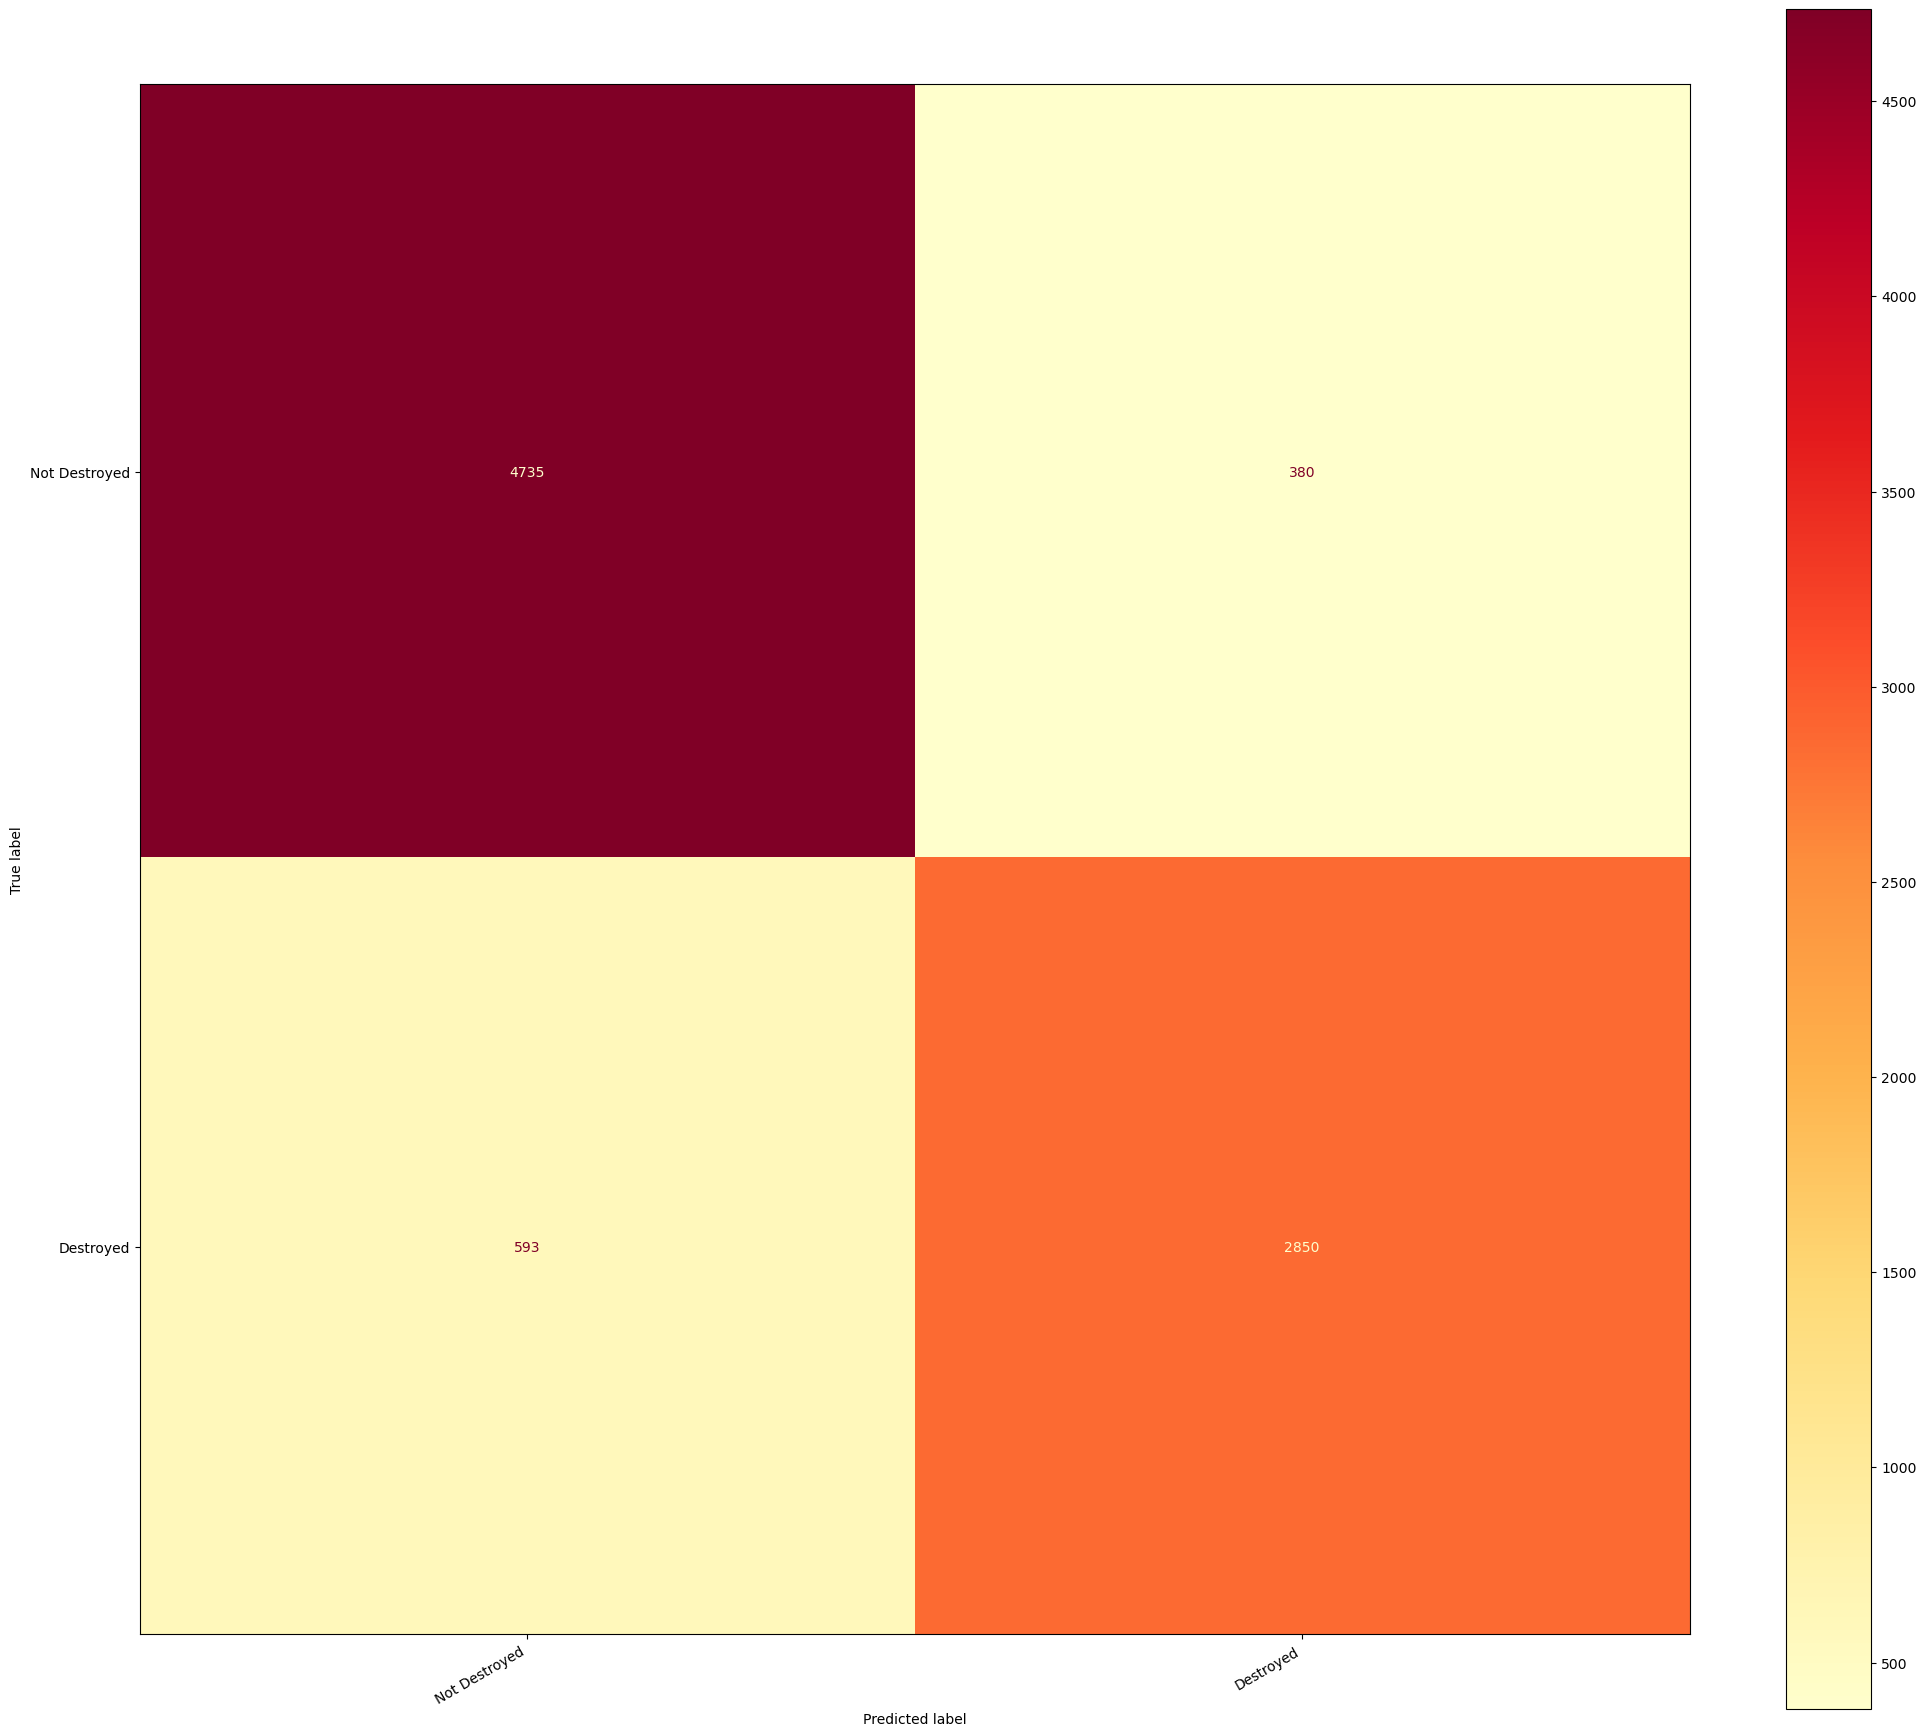

In [7]:
cm = confusion_matrix(y_test, best_tree.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(25, 25))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.show()


In [8]:
feature_df = pd.DataFrame({'feature': np.concat([pd.get_dummies(X, X.select_dtypes('object').columns).columns[4:].values, pd.get_dummies(X, X.select_dtypes('object').columns).columns[:4].values]),
                            'importance': grid_search.best_estimator_['classifier'].feature_importances_})
display(feature_df.sort_values(by=['importance'], ascending=False))


NameError: name 'np' is not defined